This method explores the genre and rating associated with the movie and the customer to develop customer vector based on the content. The recommendations are generated using this customer vector.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [5]:
movies = pd.read_csv("../../data_test/pro_movies.csv", converters={"genres": literal_eval})

In [6]:
# Load the training data
ratings_train = pd.read_csv("../../data_test/training_data.csv", converters={"genres": literal_eval, "tag": literal_eval})

In [7]:
ratings_train.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,1091,1.5,1256677471,[Comedy],[]
1,1,1257,4.5,1256677460,"[Comedy, Romance]",[]
2,1,1449,4.5,1256677264,[Comedy],[]
3,1,1590,2.5,1256677236,"[Horror, Sci-Fi, Thriller]",[]
4,1,1591,1.5,1256677475,"[Action, Adventure, Sci-Fi, Thriller]",[]


In [8]:
# Get unique genres from the data
unique_genre = movies['genres'].explode().unique()

# Get the count of each genre
genre_distribution = ratings_train['genres'].explode().value_counts()

# Make a dict assigning an index to a genre
genre_dict = {k: v for v, k in enumerate(unique_genre)}
genre_dict

{'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'IMAX': 13,
 'Documentary': 14,
 'War': 15,
 'Musical': 16,
 'Western': 17,
 'Film-Noir': 18,
 '(no genres listed)': 19}

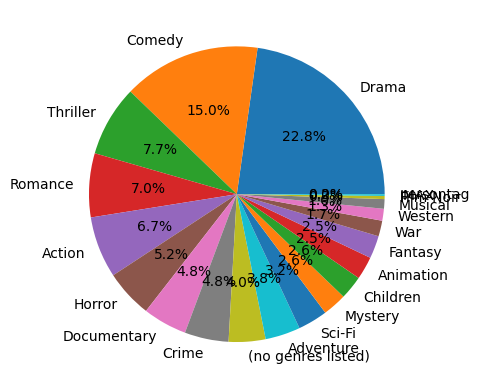

In [9]:
import matplotlib.pyplot as plt

# Calculate genre distribution
genre_distribution = movies['genres'].explode().value_counts()

# Add 'persontag' category with a count of 0 if it doesn't exist
if 'persontag' not in genre_distribution.index:
    genre_distribution['persontag'] = 0

# Plot the pie chart with percentage values
plt.pie(genre_distribution.values, labels=genre_distribution.index, autopct='%1.1f%%')

# Display the chart
plt.show()


In [10]:
# import plotly.express as px 
# fig = px.pie(genre_distribution, values = genre_distribution.values, names = genre_distribution.keys(), 
#              title='Genre distribution') 
# fig.show()
# plt.pie(genre_distribution.values, labels = genre_distribution.keys())
# plt.show()

In [11]:
# # Create an empty column named 'movie_vector' in the 'movies' DataFrame
# movies['movie_vector'] = ""

# # Iterate over each row in the 'movies' DataFrame
# for ind, row in movies.iterrows():
#     # Retrieve the 'genres' value for the current row
#     genres = row.genres

#     # Create a numpy array of zeros with the length of genre_dict
#     movie_vector = np.zeros(len(genre_dict))

#     # Iterate over each genre in the 'genres' list
#     for g in genres:
#         # Set the corresponding index of 'movie_vector' to 1 for each genre
#         movie_vector[genre_dict[g]] = 1

#     # Assign the calculated 'movie_vector' to the 'movie_vector' column for the current row
#     movies.at[ind, 'movie_vector'] = movie_vector

# # Save the modified 'movies' DataFrame to a CSV file named 'movie_vector.csv'
# movies.to_csv("movie_vector.csv")


In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Convert the lists in the "genres" column to strings
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x))

# Fit and transform the "genres" column using one-hot encoding
genre_encoded = encoder.fit_transform(movies['genres'].values.reshape(-1, 1))

# Create a DataFrame from the one-hot encoded array
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.categories_[0])

# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_encoded = pd.concat([movies, genre_encoded_df], axis=1)

# Save the final DataFrame
movies_encoded.to_csv("movie_vector.csv", index=False)


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
user_ids = ratings_train['userId'].unique()
# Get unique user IDs from the "userId" column in the "ratings_train" DataFrame

user_df = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
# Create an empty DataFrame with columns: 'userId', 'user_vector', 'avg_rating', 'num_movies_rated'

for user_id in user_ids:
    # Iterate over each unique user ID
    user_rating_df = ratings_train[(ratings_train['userId'] == user_id)]
    # Filter the "ratings_train" DataFrame to get rows where the 'userId' matches the current user ID
    
    user_vector = np.zeros(len(genre_dict))
    # Create an array of zeros with length equal to the number of genres in the "genre_dict"
    count_vector = np.zeros(len(genre_dict))
    # Create another array of zeros to keep track of the number of movies rated in each genre
    
    user_avg_rating = 0
    movies_rated_count = 0
    # Initialize variables to calculate the average rating and number of movies rated by the user
    
    for _, row in user_rating_df.iterrows():
        # Iterate over each row in the filtered DataFrame for the current user
        user_avg_rating += row.rating
        # Add the rating to the user's average rating
        movies_rated_count += 1
        # Increment the count of movies rated by the user
        
        genres = row.genres
        # Get the genres of the current movie
        
        user_movie_vector = np.zeros(len(genre_dict))
        # Create an array of zeros to represent the user's preference for each genre in the movie
        
        for g in genres:
            user_movie_vector[genre_dict[g]] = 1
            # Set the value of the corresponding genre index in the user's movie vector to 1
            count_vector[genre_dict[g]] += 1
            # Increment the count of movies rated in the genre
            
        user_vector += user_movie_vector * row.rating
        # Add the weighted movie vector to the user's overall vector based on the movie's rating

    count_vector = np.where(count_vector == 0, 1, count_vector)
    # Replace any zero values in the count vector with 1 to avoid division by zero
    user_vector = np.divide(user_vector, count_vector)
    # Divide the user vector by the count vector to get the average preference for each genre
    user_avg_rating /= movies_rated_count
    # Calculate the average rating by dividing the sum of ratings by the number of movies rated
    
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]],
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
    # Create a DataFrame with the user ID, user vector, average rating, and number of movies rated
    user_df = pd.concat([user_df, row_df], ignore_index=True)
    # Concatenate the row DataFrame with the user DataFrame
# After the loop finishes, the user_df DataFrame will contain the user vectors, average ratings,
# and number of movies rated for each user


In [ ]:
# Save the final dataframe
user_df.to_csv("user_info.csv")

In [ ]:
user_df.head()

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[4.391891891891892, 4.6521739130434785, 4.4857...",4.376344,186
1,2,"[4.166666666666667, 0.0, 0.0, 4.2, 0.0, 4.5, 3...",3.934783,23
2,3,"[2.5, 0.5, 0.5, 0.5, 4.333333333333333, 0.5, 0...",2.387097,31
3,4,"[3.4782608695652173, 4.0, 3.7777777777777777, ...",3.485549,173
4,5,"[3.1666666666666665, 4.25, 4.0, 3.363636363636...",3.600000,35


In [ ]:
ratings_test = pd.read_csv("testing_data.csv", converters={"genres": literal_eval, "tag": literal_eval}) 
ratings_test.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,3,4.0,964981247,"[Comedy, Romance]",[]
1,1,163,5.0,964983650,"[Action, Romance, Western]",[]
2,1,316,3.0,964982310,"[Action, Adventure, Sci-Fi]",[]
3,1,349,4.0,964982563,"[Action, Crime, Drama, Thriller]",[]
4,1,441,4.0,964980868,[Comedy],[]


### Next  few cells for sample test data point

In [ ]:
ratings_test.iloc[0]

userId                       1
movieId                      3
rating                       4
timestamp            964981247
genres       [Comedy, Romance]
tag                         []
Name: 0, dtype: object

In [ ]:
user_rating_df[user_rating_df['movieId']==6]

,userId,movieId,rating,timestamp,genres,tag
79628,610,6,5.0,1493850345,"[Action, Crime, Thriller]",[]


In [ ]:
genres = user_rating_df[user_rating_df['movieId']==6].genres.values[0]
vector = np.zeros(len(genre_dict))
for g in genres:
    vector[genre_dict[g]] = 1
print(vector)

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
user_df[user_df['userId']==1].user_vector[0]

array([4.39189189, 4.65217391, 4.48571429, 4.26760563, 4.24390244,
       4.33333333, 4.53846154, 4.33333333, 4.39393939, 4.05      ,
       3.58333333, 4.28571429, 4.19354839, 4.61111111, 4.63157895,
       0.        , 0.        , 4.4       , 5.        , 0.        ])

In [ ]:
x = vector*user_df[user_df['userId']==1].user_vector[0]
np.nanmean(np.where(x!=0,x,np.nan)) 

4.259090909090909

### Test on entire test data

In [ ]:
# Load the already calculated data from csvs
# user_df = pd.read_csv("user_info.csv", converters={"user_vector": pd.array})
# movies_df = pd.read_csv("movie_vector.csv", converters={"movie_vector": pd.array})

In [ ]:
algo_predictions = pd.DataFrame(columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
for ind, row in ratings_test.iterrows():
    userId = row['userId']
    movieId = row['movieId']
    og_rating = row['rating']
#     print(userId)
#     print(movieId)
    
    try:
        user_vector = user_df[user_df['userId'] == int(userId)].user_vector.values[0]
        movie_vector = movies[movies['movieId'] == int(movieId)].movie_vector.values[0]
    #     print(user_vector)
    #     print(movie_vector)

        predicted_rating = user_vector*movie_vector
    #     print(predicted_rating)
        
        if predicted_rating.any():
            predicted_rating = np.nanmean(np.where(predicted_rating!=0, predicted_rating, np.nan)) 
    #     print(predicted_rating)
        else:
            predicted_rating = 0

        row_df = pd.DataFrame([[userId, movieId, user_vector, movie_vector, og_rating, predicted_rating]], 
                    columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
        algo_predictions = pd.concat([algo_predictions, row_df], ignore_index=True)
    except:
        print("User not found: ", userId)

In [ ]:
rmse = ((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2).mean() ** .5
rmse

0.9185496972723388

In [ ]:
mae = (((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2) ** .5).mean()
mae

0.7095402988159346